## Set up environment paths

In [29]:
import setup
setup.main()
RAW_DIR, BINNED_DIR = setup.get_data_dir()

%load_ext autoreload
%autoreload 2

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
The raw data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/raw.
The binned data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import viz
import neuralgeom.datasets.utils as utils
import neuralgeom.datasets.experimental as experimental


## Inspect Raw Data

In [176]:
expt_id = "34"

expt = utils.loadmat(os.path.join(RAW_DIR, f"expt{expt_id}.mat"))

metadata = list(expt["x"].keys())
print(f"You can find metadata about:\n {metadata}.")

You can find metadata about:
 ['rat', 'day', 'epoch', 'type', 'finalGain', 'rosdata', 'clust', 'specGain'].


In [32]:
rat_id = expt["x"]["rat"]
print(f"The data was collected from rat {rat_id}.")

day = expt["x"]["day"]
print(f"The data was collected on day {day}.")

n_cells = len(expt["x"]["clust"])
print(f"There are {n_cells} neurons recorded in this experiment.")

epoch = expt["x"]["epoch"]
print(f"Epoch =  {epoch}")

final_gain = expt["x"]["finalGain"]
print(f"Final gain =  {final_gain}")

The data was collected from rat 637.
The data was collected on day 6.
There are 40 neurons recorded in this experiment.
Epoch =  m1
Final gain =  1


## Define experimental variables


- startTs: time in microseconds 

- stopTs: time in microseconds 

- encTimes: "encoder" times 

- encAngle: recorded angles of rat

- subepochs: "m1" exprrimental session, + periods where gain eitehr takes a different value or changes

- landAngle: angle of landmark frame

- gain: 

- vel: velocity of rat (degrees/s - close to cm/s here)

- relAngle: encAngle - landAngle

- landOffTime: when landmamarks turned off

- landOffAngle: encAngle(landOfftime) -- encAngle[landOffIdx]

- landOffIdx: index of lanfOffAngle

- estGain: gain estimated through Fourier analysis

- hippAngle: integral of G d$\theta$ angle of rat in estimated hippocampal frame

## Load neural activity + measured lab variables ("labels")

In [250]:
# assuming df is your DataFrame and it has columns 'time' and 'value'
# and 'time' is in datetime format

def velocity_threshold(expt):
    df = pd.DataFrame({k: pd.Series(v) for k, v in expt["x"]["rosdata"].items()})
    df = df.drop(index=["name","startTs","stopTs"])

    # setting threshold
    threshold = 5

    # create a new column 'above_threshold' to indicate whether the value is above the threshold
    df['above_threshold'] = df['vel'] > threshold

    # find the periods where the value rises above and then dips below the threshold
    df['rise_event'] = np.ceil(df['above_threshold'].diff()[1:].ne(0).cumsum()/2)

    # Compute the lengths of the rises
    rise_lengths_microseconds = df[df['above_threshold']].groupby('rise_event').apply(lambda x: x['encTimes'].max() - x['encTimes'].min())


    df['above_threshold'] = df['above_threshold'].astype(int)

    # Convert lengths from microseconds to seconds
    rise_lengths_in_seconds = rise_lengths_microseconds / 1_000_000


    # then you can analyze the lengths, for example, plot a histogram
    counts, bins, _ = plt.hist(rise_lengths_in_seconds, bins=300)
    plt.xlabel('Length of rise events (seconds)')
    plt.ylabel('Count')

    print(f"Mean rise length: {rise_lengths_in_seconds.mean()} seconds")
    print(f"Median rise length: {rise_lengths_in_seconds.median()} seconds")
    print(f"Total number of rise events: {len(rise_lengths_in_seconds)}")

    bump_start_times = []
    bump_end_times = []

    difference = df["above_threshold"].diff()

    if df["above_threshold"][0] == 1:
        bump_start_times.append(df["encTimes"][0])

    for i in range(1, len(difference)):
        if difference[i] == 0:
            pass
        elif difference[i] == 1:
            start_time = df["encTimes"][i]
            bump_start_times.append(start_time)
        elif difference[i] == -1:
            end_time = df["encTimes"][i]
            bump_end_times.append(end_time)

    if df["above_threshold"][len(df["above_threshold"]) - 1] == 1:
        bump_end_times.append(df["encTimes"][len(df["above_threshold"]) - 1])

    bump_start_times = np.array(bump_start_times)
    bump_end_times = np.array(bump_end_times)

    return bump_start_times, bump_end_times

In [251]:
def get_sampling_times(bump_start_times, bump_end_times, timestep_microseconds):
    all_times = []
    for i in range(len(bump_start_times)):
        if bump_end_times[i] - bump_start_times[i] > timestep_microseconds:
            times = []
            t = bump_start_times[i]
            while t < bump_end_times[i]:
                times.append(t)
                t += timestep_microseconds
            all_times.append(times)

    return all_times

Mean rise length: 0.8449574409793814 seconds
Median rise length: 0.42016875 seconds
Total number of rise events: 970


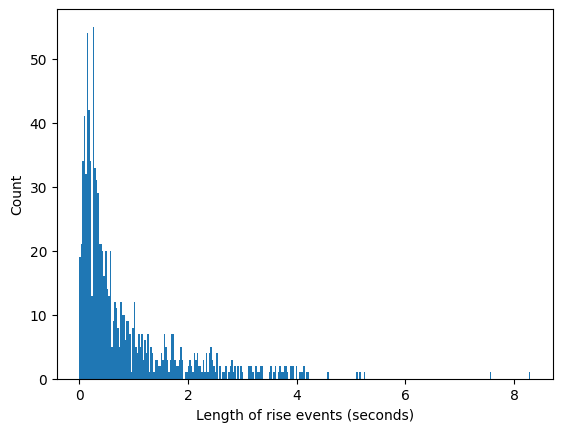

In [252]:
bump_start_times, bump_end_times = velocity_threshold(expt)

timestep_microseconds = int(1e5)

sampling_times = get_sampling_times(bump_start_times, bump_end_times, timestep_microseconds)

In [267]:
print(f"There are {len(sampling_times)} valid time periods of duration AT LEAST {timestep_microseconds} microseconds")

There are 891 valid time periods of duration AT LEAST 100000 microseconds


In [269]:
neural_activity = []

for neuron_index, neuron in enumerate(expt["x"]["clust"]):
    neuron_i_activity = []
    for times in sampling_times:
            spike_count, _ = np.histogram(neuron["ts"], bins=times)
            neuron_i_activity.extend(spike_count)
            
    neural_activity.append(neuron_i_activity)

In [ ]:
thresh_times = []
angles = []
vel = []

for time in sampling_times:
    

In [214]:
bump_start_times = []
bump_end_times = []

difference = df["above_threshold"].diff()

if df["above_threshold"][0] == 1:
    bump_start_times.append(df["encTimes"][0])

for i in range(1, len(difference)):
    if difference[i] == 0:
        pass
    elif difference[i] == 1:
        start_time = df["encTimes"][i]
        bump_start_times.append(start_time)
    elif difference[i] == -1:
        end_time = df["encTimes"][i]
        bump_end_times.append(end_time)

if df["above_threshold"][len(df["above_threshold"]) - 1] == 1:
    bump_end_times.append(df["encTimes"][len(df["above_threshold"]) - 1])

bump_start_times = np.array(bump_start_times)
bump_end_times = np.array(bump_end_times)

In [ ]:
 
def get_sampling_times()
    for i in range(len(bump_start_times)):
        if bump_end_times[i] - bump_start_times[i] > timestep_microseconds:
            times = []
            t = bump_start_times[i]
                while t < bump_end_times[i]:
                    times.append(t)
                    t += timestep_microseconds


for neuron_index, neuron in enumerate(expt["x"]["clust"]):
    neuron_i_activity = []

            spike_count, _ = np.histogram(neuron["ts"], bins=times)
            neuron_i_activity.extend(spike_count)
            
    neural_activity.append(neuron_i_activity)

In [246]:
expt["x"]["rosdata"]["encTimes"]

array([3.61160505e+08, 3.61171038e+08, 3.61180586e+08, ...,
       3.32406152e+09, 3.32407161e+09, 3.32408187e+09])

In [244]:
expt["x"]["clust"][0]["ts"]

array([3.68628787e+08, 3.68635519e+08, 3.68852857e+08, ...,
       3.07833970e+09, 3.07834393e+09, 3.28162030e+09])

In [215]:
# why is this different from rise_lengths_microseconds ??
bump_lengths = bump_end_times - bump_start_times

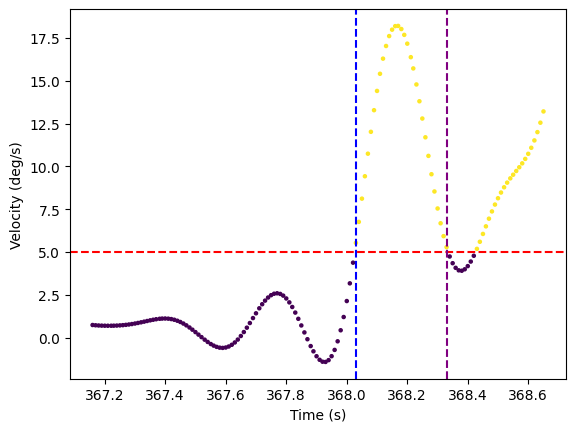

In [232]:
times_secs = df['encTimes'][600:750]*1e-6
velocities = df['vel'][600:750]
colors = df['above_threshold'][600:750]


plt.scatter(times_secs, velocities, c=colors, cmap='viridis',s=5)
plt.axhline(y=5, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (deg/s)')

# # for i in range(1,2):
# #     plt.axvline(x=bump_start_times[i]*1e-6, color='blue', linestyle='--')
# #     plt.axvline(x=bump_end_times[i]*1e-6, color='purple', linestyle='--')
# plt.axvline(x=bump_start_times[1]*1e-6, color='blue', linestyle='--')
# plt.axvline(x=bump_start_times[1]*1e-6 + rise_lengths_microseconds[2]*1e-6, color='purple', linestyle='--')

In [15]:
import neuralgeom.datasets.experimental as experimental

expt_id = "34"
timestep_microseconds = int(1e6)

neural_activity, labels = experimental.load_neural_activity(expt_id=expt_id, timestep_microsec=timestep_microseconds)

times_in_seconds = labels["times"]*1e-6
angles = labels["angles"]

print(f"There are {neural_activity.shape[1]} neurons binned over {neural_activity.shape[0]} timesteps")

INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_times_timestep1000000.txt! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_neural_activity_timestep1000000.npy! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_labels_timestep1000000.txt! Loading...


There are 40 neurons binned over 2953 timesteps


In [16]:
neural_activity.shape

(2953, 40)

In [17]:
labels

,Unnamed: 0,times,angles,velocities,gains
0,0,3.625397e+08,125.815085,-0.104195,1.0
1,1,3.635397e+08,129.515412,13.455259,1.0
2,2,3.645397e+08,154.552048,30.988614,1.0
3,3,3.655397e+08,184.048601,27.353089,1.0
4,4,3.665397e+08,212.071814,28.240268,1.0
...,...,...,...,...,...
2948,2948,3.310540e+09,37.660339,0.094720,1.0
2949,2949,3.311540e+09,38.190007,1.087265,1.0
2950,2950,3.312540e+09,38.595808,-1.100449,1.0
2951,2951,3.313540e+09,46.685671,16.660279,1.0


Visualize activity over time (PSTH) -- no speed thresholding

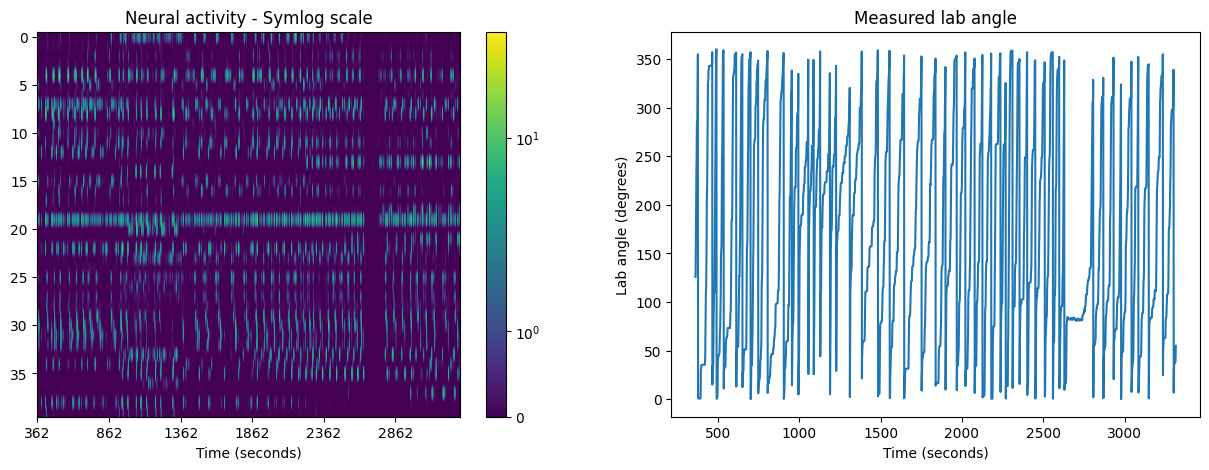

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))

psth = axs[0].imshow(neural_activity.T, aspect="auto",cmap="viridis",norm="symlog")
axs[0].set_title("Neural activity - Symlog scale")
axs[0].set_xticks(np.arange(len(times_in_seconds))[::500])
axs[0].set_xticklabels(times_in_seconds[::500].astype(int))
axs[0].set_xlabel("Time (seconds)")

fig.colorbar(psth,ax=axs[0])

axs[1].plot(times_in_seconds, angles)
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Lab angle (degrees)")
axs[1].set_title("Measured lab angle");

Apply threshold speed = 5 cm/s (place cell activity occurs when rat in motion)

In [19]:
neural_activity = neural_activity[labels["velocities"]>5]

labels = labels[labels["velocities"]>5]
print(f"There are {neural_activity.shape[0]} timesteps where the rat's speed was greater than 5 cm/s")

times_in_seconds = labels["times"]*1e-6
angles = labels["angles"]

There are 934 timesteps where the rat's speed was greater than 5 cm/s


Visualize activity vs angles ("Peristimulus Angle Histogram")

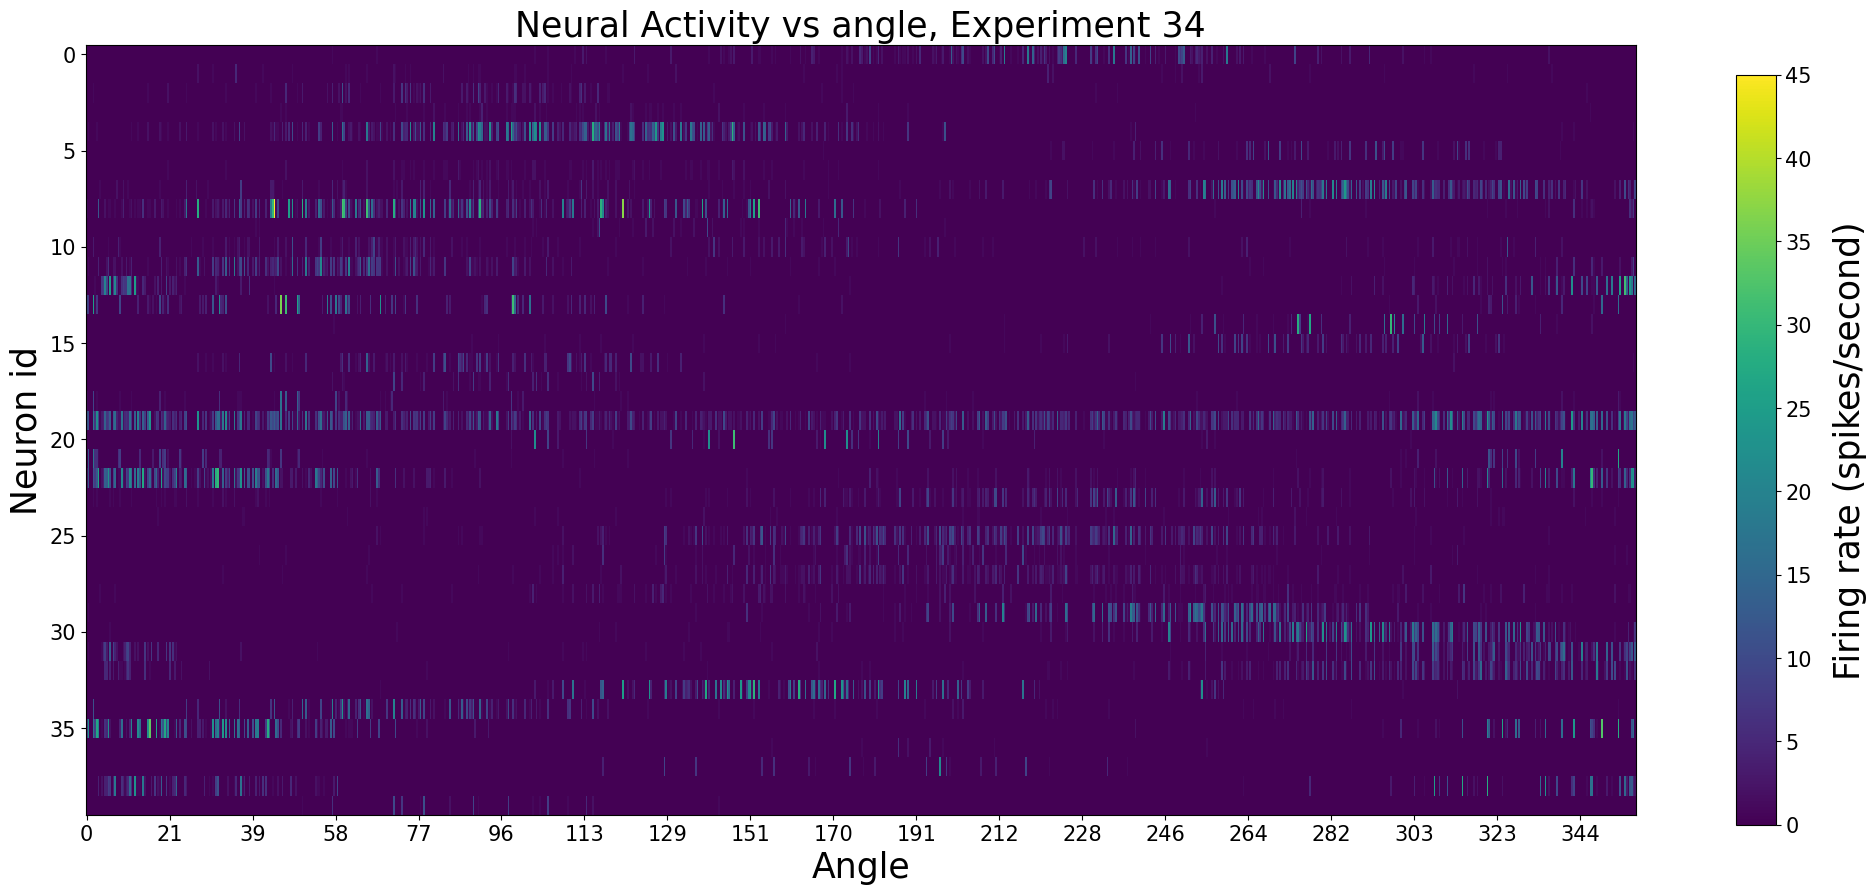

In [20]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]
fig, axs = plt.subplots(figsize=(20, 10))
psah = axs.imshow(sorted_neural_activity.T, aspect="auto",cmap="viridis",interpolation="none")
axs.set_title(f"Neural Activity vs angle, Experiment {expt_id}",fontsize=25)
axs.set_xticks(np.arange(len(sorted_angles))[::50])
axs.set_xticklabels(sorted_angles[::50].astype(int))
axs.set_xlabel("Angle",fontsize=25)
axs.set_ylabel("Neuron id",fontsize=25)
axs.tick_params(axis='both', which='major', labelsize=15)


cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])


cbar = fig.colorbar(psah, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

## Option: Smooth binned data?

### Smooth wrt time

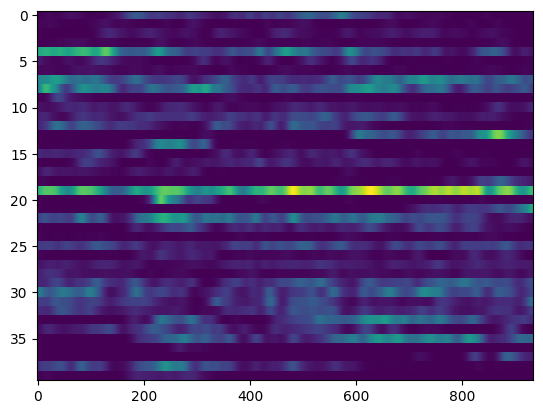

In [21]:
from scipy.ndimage.filters import gaussian_filter1d

# Apply the Gaussian filter to smooth the spike train
# 'sigma' is the standard deviation of the Gaussian kernel, in units of time bins
sigma = 10
smoothed_neural_activity = gaussian_filter1d(neural_activity.astype(float),sigma, axis=0)

plt.imshow(smoothed_neural_activity.T,aspect="auto",interpolation="none")

### Smooth wrt angle

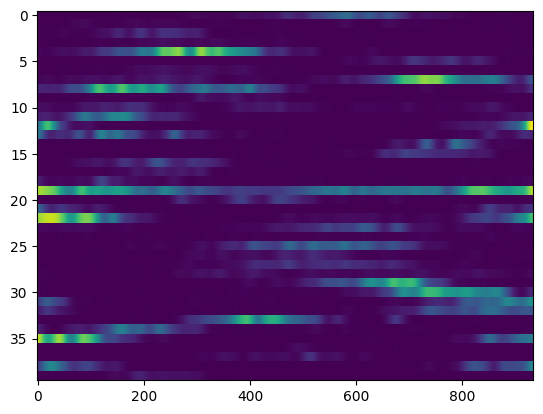

In [22]:
from scipy.ndimage.filters import gaussian_filter1d

# Apply the Gaussian filter to smooth the spike train
# 'sigma' is the standard deviation of the Gaussian kernel, in units of time bins
sigma = 10
smoothed_sorted_neural_activity = gaussian_filter1d(sorted_neural_activity.astype(float),sigma, axis=0)

plt.imshow(smoothed_sorted_neural_activity.T,aspect="auto",interpolation="none")

## Isolate "canonical" place cells

Calculate Mutual Information between angular position and activity for each neuron

!!!!!TODO!!!!!: 

account for topology of angular variable. Maybe turn $\theta$ -> $(\cos{\theta},\sin{\theta})$ and use multivariate MI? 

What are other tests of independence/ correlation coefficiens?

See:
- https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
- https://arxiv.org/pdf/1307.7383.pdf
- https://arxiv.org/pdf/1909.10140.pdf
- https://github.com/minepy/mictools

### Mutual Information between position $\theta$ and neural activity

In [23]:
from sklearn.feature_selection import mutual_info_regression

angles_radians=angles*np.pi/180

spatial_mutual_info = mutual_info_regression(neural_activity,angles_radians)

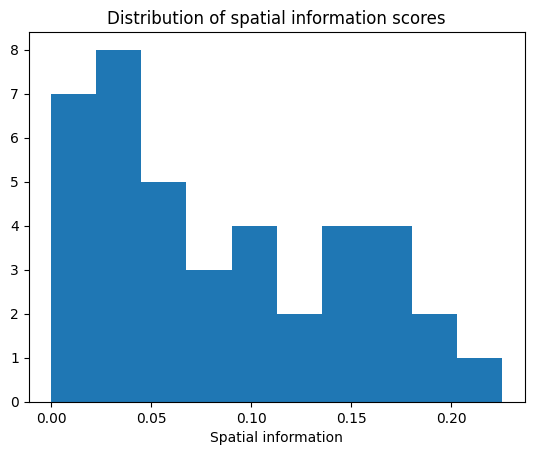

In [24]:
hist = plt.hist(spatial_mutual_info)
plt.xlabel("Spatial information")
plt.title("Distribution of spatial information scores");

Set a MI threshold

In [25]:
threshold = 0.1

In [26]:
mi_thresh_neural_activity = neural_activity[:,spatial_mutual_info>threshold]
mi_thresh_spatial_mutual_info = spatial_mutual_info[spatial_mutual_info>threshold]

print(f"there are {len(mi_thresh_spatial_mutual_info)} neurons with spatial information above {threshold}")

there are 16 neurons with spatial information above 0.1


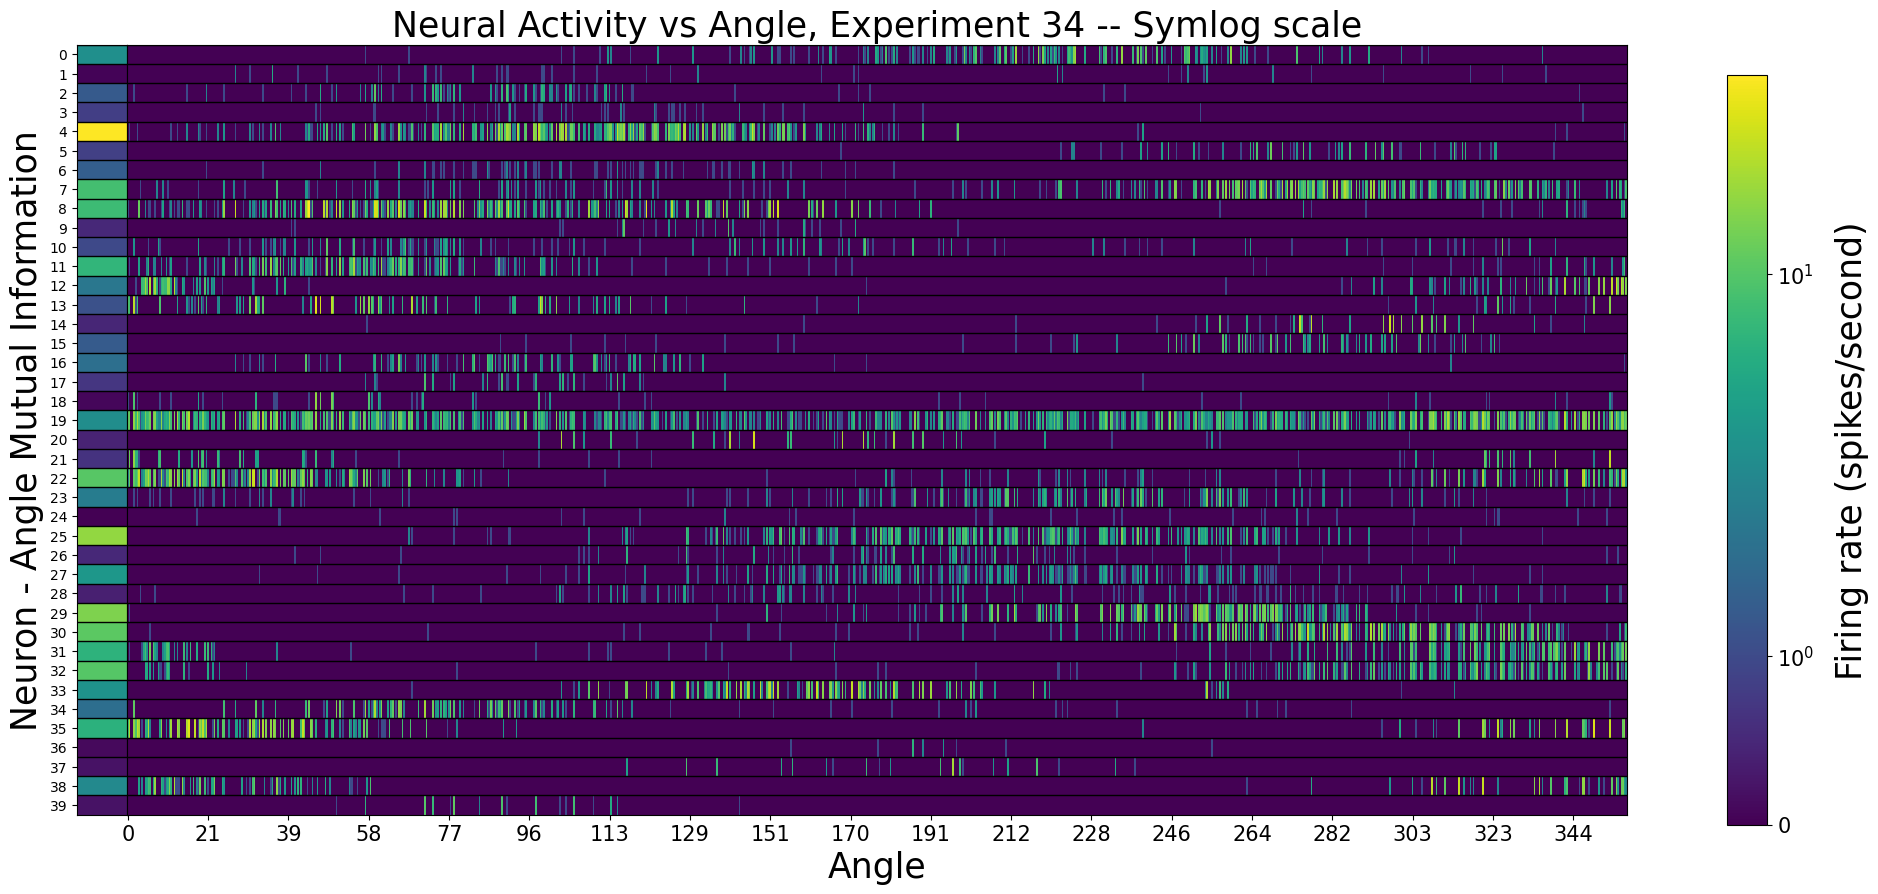

In [27]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]

viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=sorted_neural_activity,task_variable=sorted_angles,mutual_info=spatial_mutual_info)

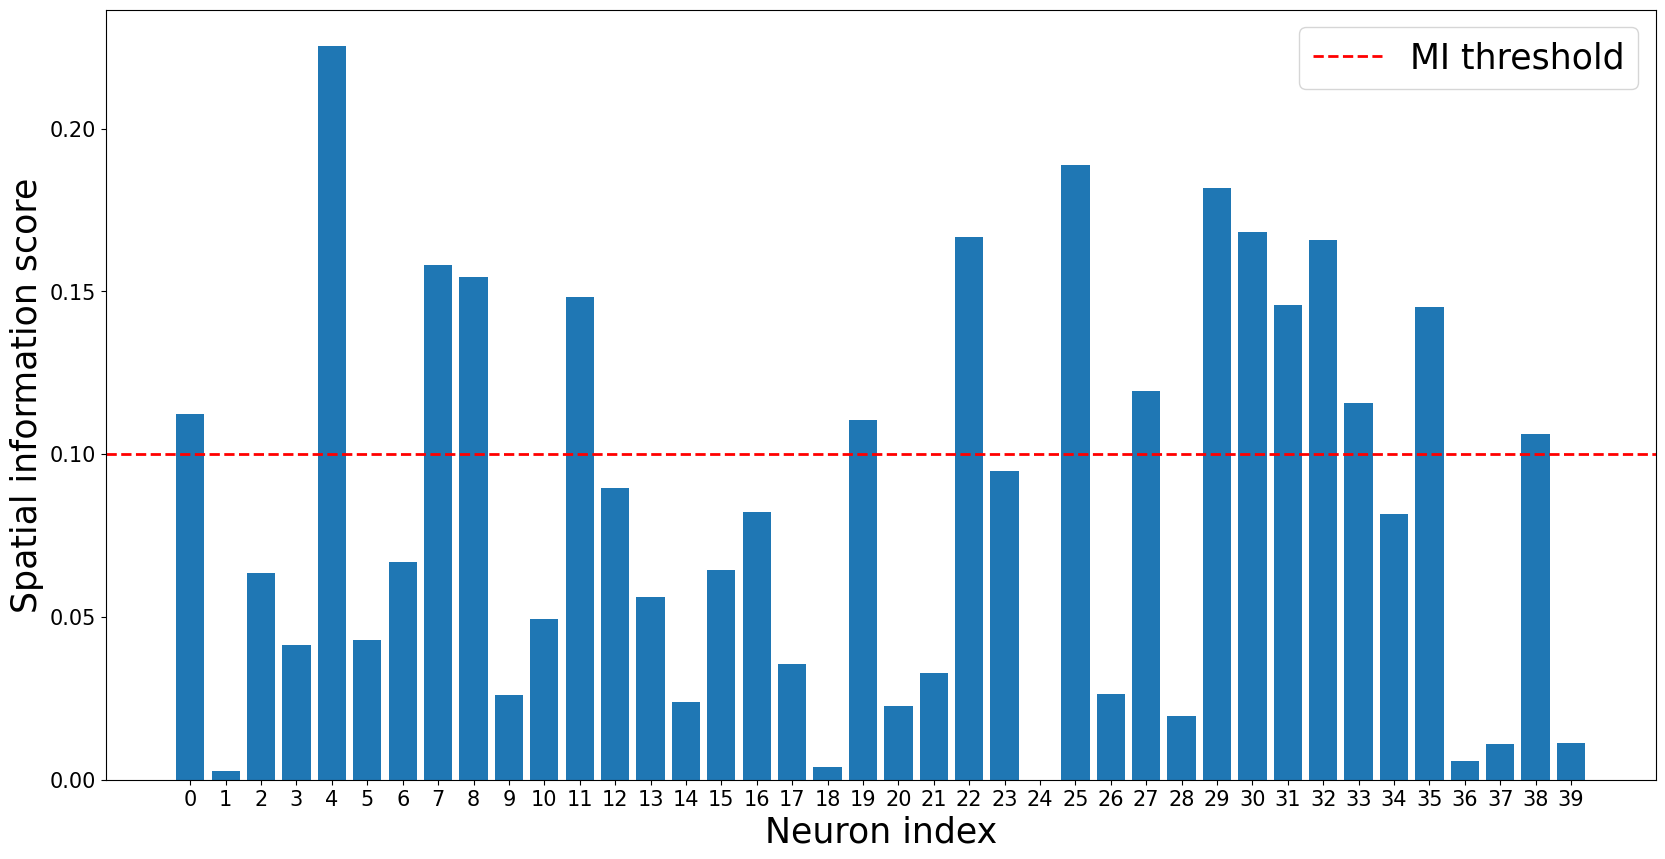

In [28]:
x_ticks = np.arange(0,len(spatial_mutual_info))

fig, ax = plt.subplots(figsize=(20,10))

# Plot the barograph
ax.bar(x_ticks, spatial_mutual_info)

# Set the x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks);
ax.set_xlabel("Neuron index",fontsize=25)
ax.set_ylabel("Spatial information score",fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.axhline(threshold, color='red', lw=2, linestyle='--',label="MI threshold")
ax.legend(fontsize=25);

Visualize PSAH for neurons with high spatial information

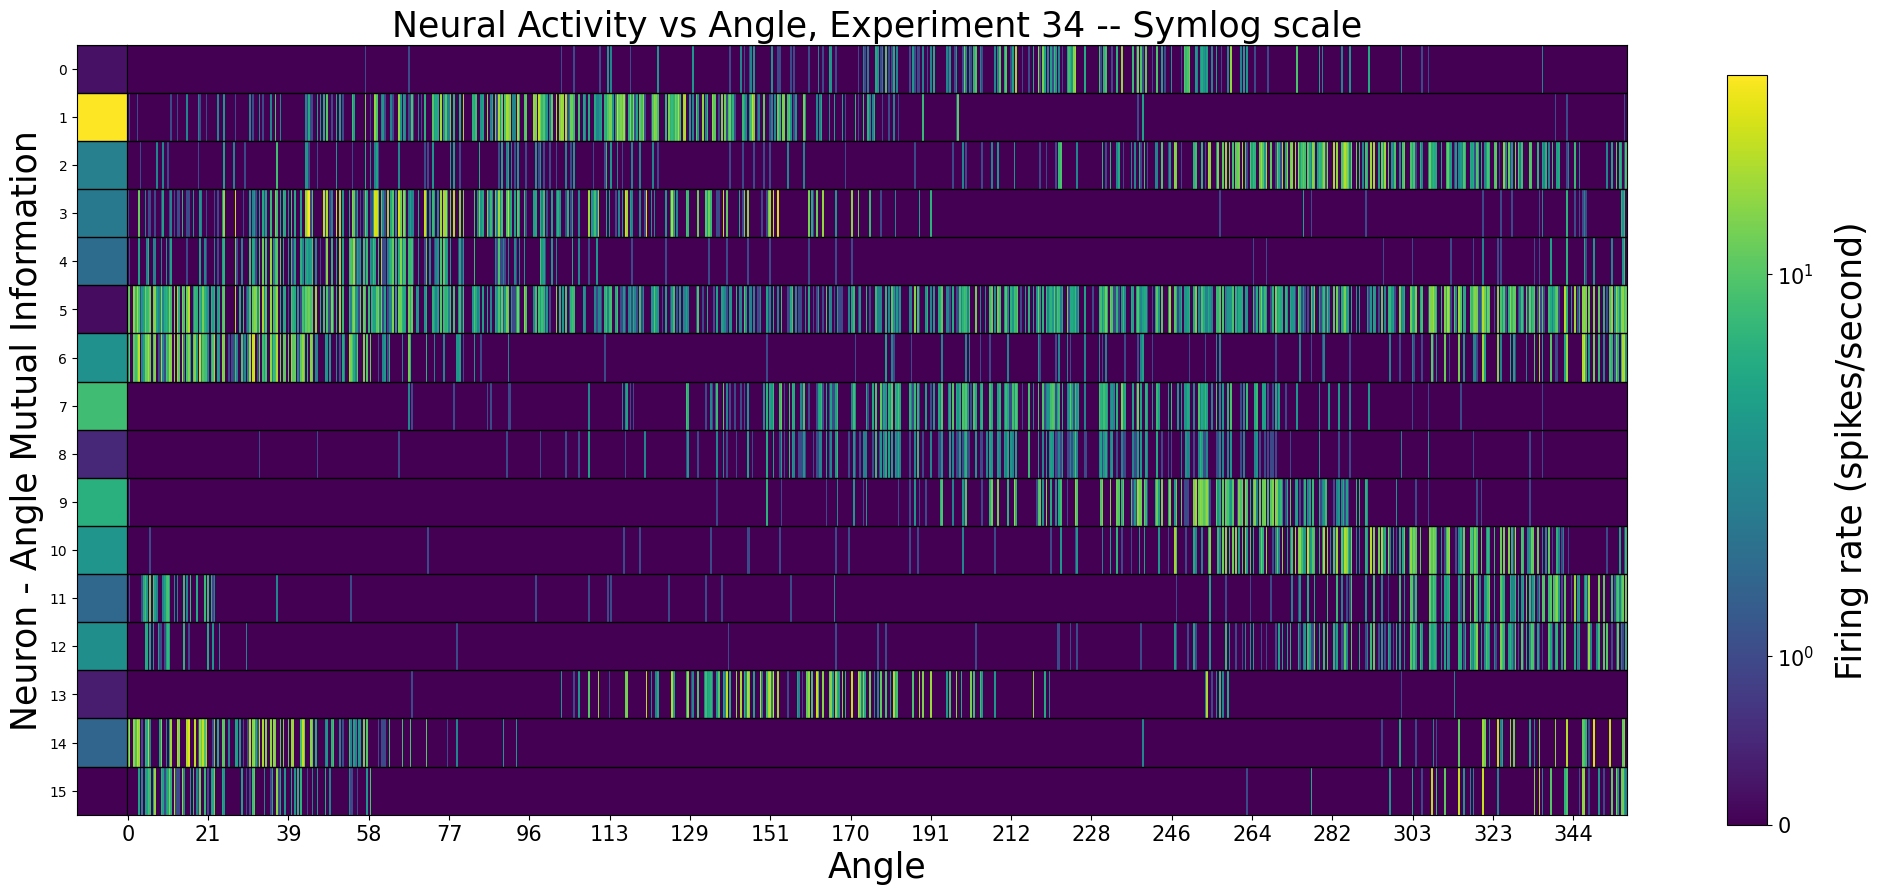

In [29]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_mi_thresh_neural_activity = mi_thresh_neural_activity[sort, :]

viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=sorted_mi_thresh_neural_activity,task_variable=sorted_angles,mutual_info=mi_thresh_spatial_mutual_info)

### Mutual information between neural activity and $\cos{\theta}$, $\sin{\theta}$

In [30]:
angles_radians = angles*np.pi/180

X = np.cos(angles_radians)
Y = np.sin(angles_radians)

spatial_mutual_info_X = mutual_info_regression(neural_activity,X)
spatial_mutual_info_Y = mutual_info_regression(neural_activity,Y)
spatial_mutual_info_XY = spatial_mutual_info_X + spatial_mutual_info_Y

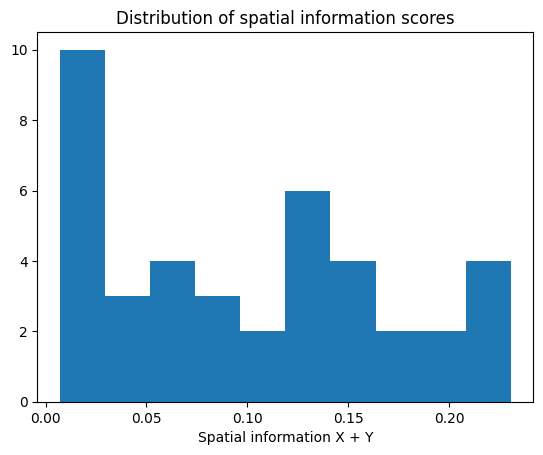

In [31]:
plt.hist(spatial_mutual_info_XY)
plt.xlabel("Spatial information X + Y")
plt.title("Distribution of spatial information scores");

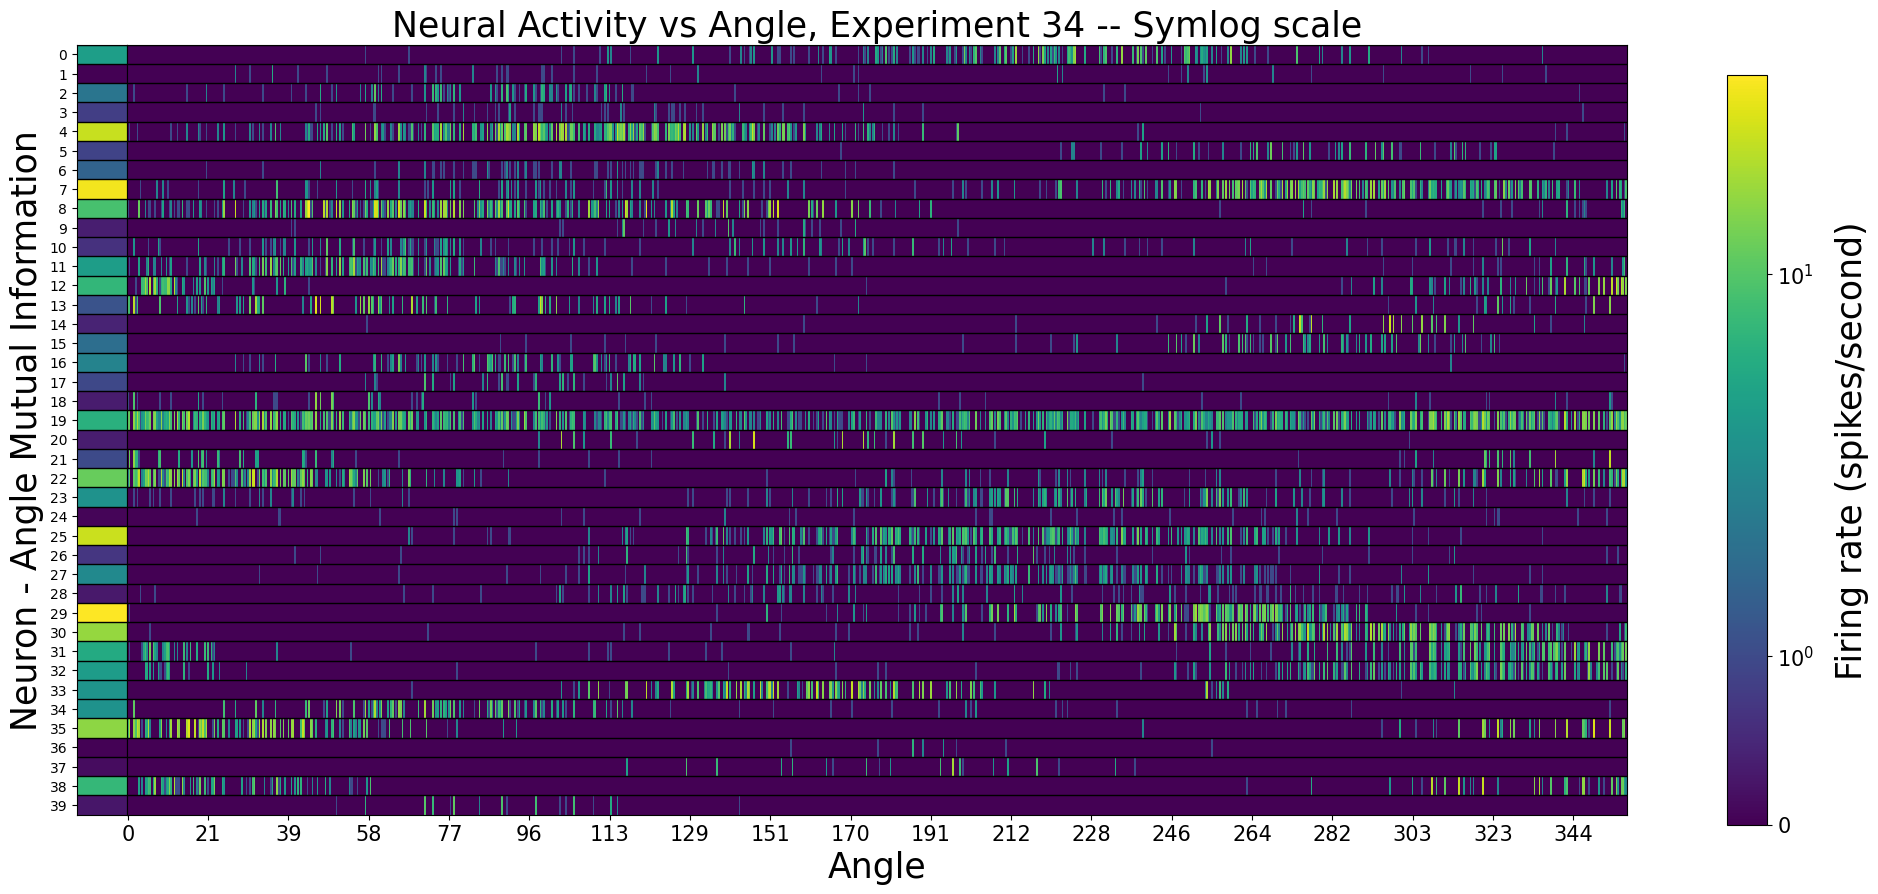

In [32]:
viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=sorted_neural_activity,task_variable=sorted_angles,mutual_info=spatial_mutual_info_XY)

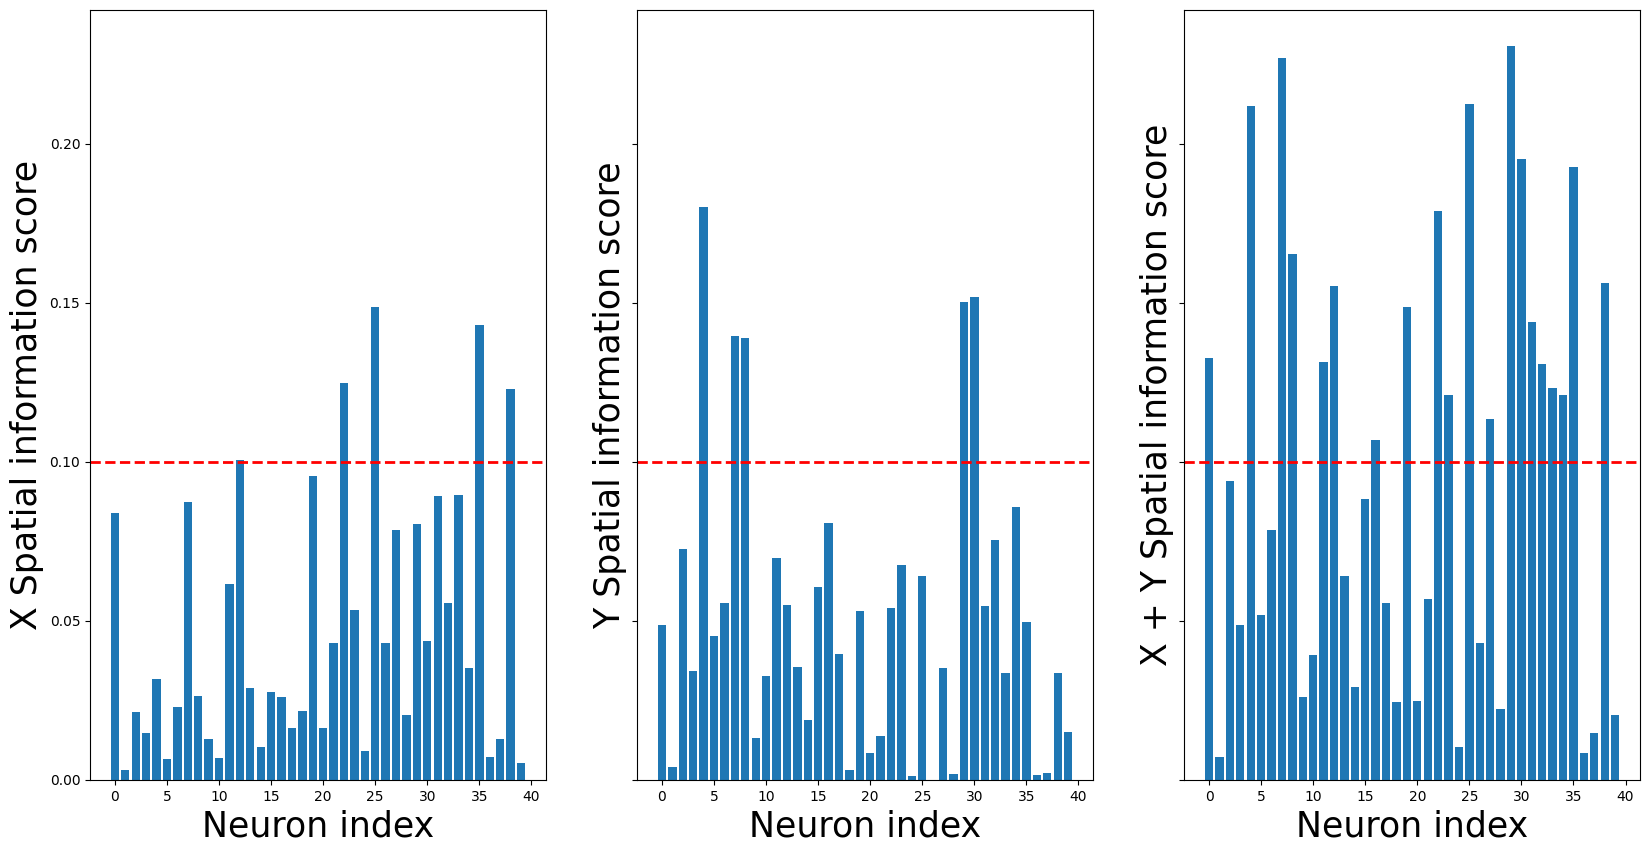

In [33]:
fig, axs = plt.subplots(1,3,figsize=(20,10),sharey=True)
axs[0].bar(x_ticks, spatial_mutual_info_X)
axs[0].set_xlabel("Neuron index",fontsize=25)
axs[0].set_ylabel("X Spatial information score",fontsize=25)
axs[0].axhline(threshold, color='red', lw=2, linestyle='--',label="MI threshold")

axs[1].bar(x_ticks, spatial_mutual_info_Y)
axs[1].set_xlabel("Neuron index",fontsize=25)
axs[1].set_ylabel("Y Spatial information score",fontsize=25)
axs[1].axhline(threshold, color='red', lw=2, linestyle='--',label="MI threshold")

axs[2].bar(x_ticks, spatial_mutual_info_XY)
axs[2].set_xlabel("Neuron index",fontsize=25)
axs[2].set_ylabel("X + Y Spatial information score",fontsize=25)
axs[2].axhline(threshold, color='red', lw=2, linestyle='--',label="MI threshold");

Set Spatial Mutual Information threshold

In [34]:
mi_thresh_neural_activity = neural_activity[:,spatial_mutual_info_XY>threshold]
mi_thresh_spatial_mutual_info = spatial_mutual_info_XY[spatial_mutual_info_XY>threshold]

print(f"there are {len(mi_thresh_spatial_mutual_info)} neurons with spatial information above {threshold}")

there are 20 neurons with spatial information above 0.1


Visualize PSAH for neurons with high spatial information

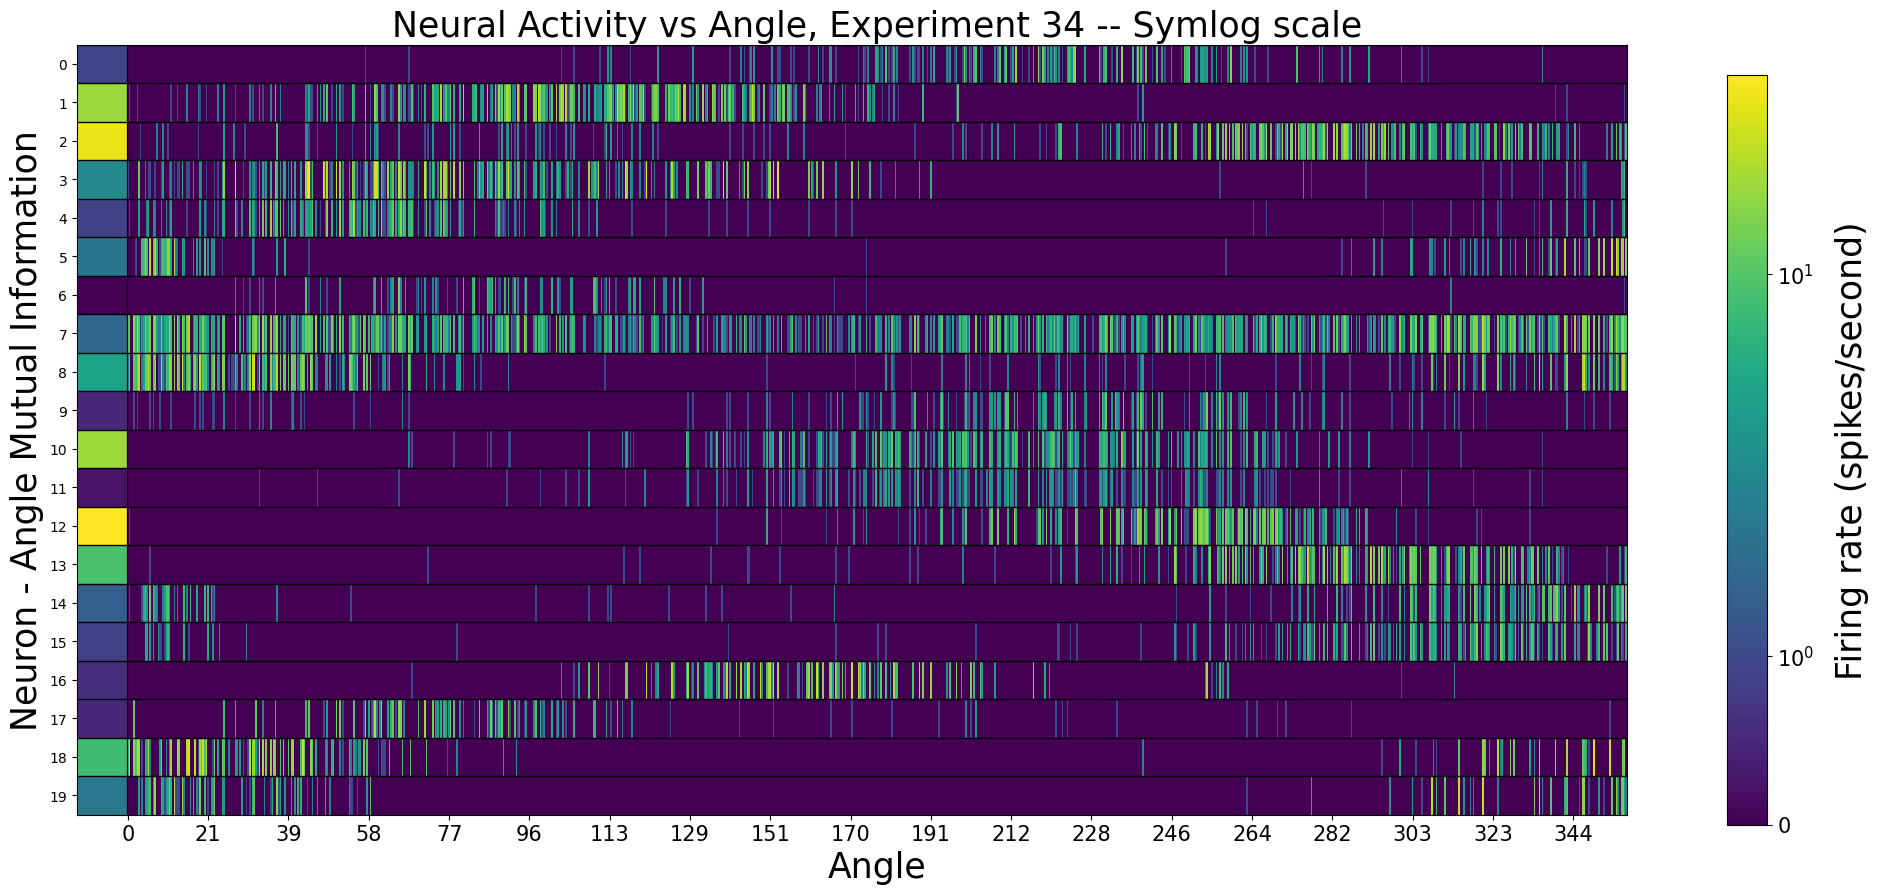

In [35]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_mi_thresh_neural_activity = mi_thresh_neural_activity[sort, :]

viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=sorted_mi_thresh_neural_activity,task_variable=sorted_angles,mutual_info=mi_thresh_spatial_mutual_info)

### Organize neurons according to place field center of mass + visualize

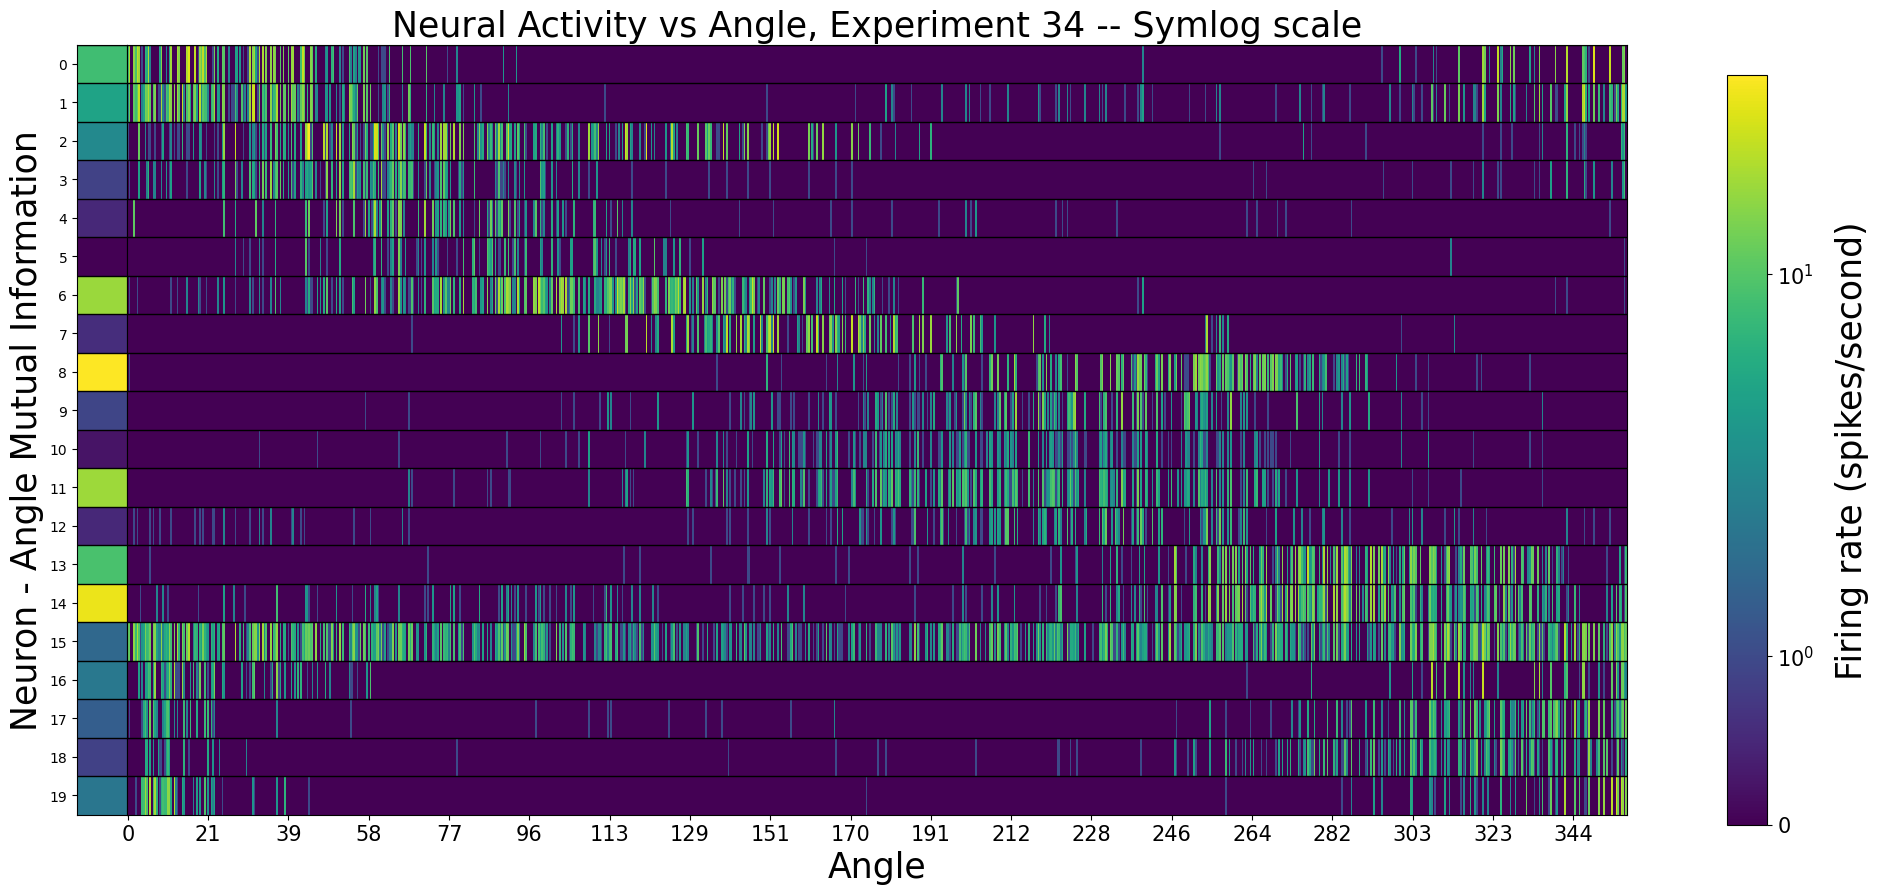

In [36]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]

center_of_mass, center_of_mass_indices = experimental.get_place_field_centers(sorted_mi_thresh_neural_activity, sorted_angles)
com_sort = np.argsort(center_of_mass_indices)

organized_neural_activity = sorted_mi_thresh_neural_activity[:,com_sort]
organized_spatial_mutual_info = mi_thresh_spatial_mutual_info[com_sort]

viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=organized_neural_activity,task_variable=sorted_angles,mutual_info=organized_spatial_mutual_info)

## Run PCA

Find the eigenspectrum. How does it decay? --> Is the neural manifold "Smooth"?

See: https://www.nature.com/articles/s41586-019-1346-5

## Train Decoder FFNN

In [37]:
neural_activity.shape

(934, 40)

In [38]:
# copy archtecture from VAE encoder

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Set a fixed random seed for reproducibility
torch.manual_seed(0)


input_dim = neural_activity.shape[1]

# Define a simple feedforward neural network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50).float()  # First hidden layer
        self.fc2 = nn.Linear(50, 20).float()  # Second hidden layer
        self.fc3 = nn.Linear(20, 2).float()  # Output layer

    def forward(self, x):
        x = x.float()
        x = F.relu(self.fc1(x))  # Apply ReLU activation function after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation function after second layer
        x = self.fc3(x)  # No activation function after final layer (for regression task)
        return x

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [40]:
# Create an instance of the network
decoder = Decoder().to(device)

# Use mean squared error loss for regression
criterion = nn.MSELoss()

# use adam optimizer
optimizer = optim.Adam(decoder.parameters(), lr=0.01)

In [41]:
cos_sin_angles = np.vstack((np.cos(angles_radians),np.sin(angles_radians))).T

In [42]:
# Assume we have some training data in input_data (100-dimensional input) and target_data (2-dimensional output)
input_data = torch.from_numpy(neural_activity).float().to(device)
target_data = torch.from_numpy(cos_sin_angles).float().to(device)

# Split data into training and validation sets (80-20 split)
train_size = int(0.8 * len(input_data))
val_size = len(input_data) - train_size

train_data = TensorDataset(input_data[:train_size], target_data[:train_size])
val_data = TensorDataset(input_data[train_size:], target_data[train_size:])

# Create DataLoaders from your datasets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

In [43]:
# Arrays to keep track of losses
train_losses = []
val_losses = []


# Train the network
for epoch in range(10):  # Loop over the dataset multiple times
    # Training phase
    decoder.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = decoder(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss}")

    # Validation phase
    decoder.eval()
    with torch.no_grad():
        running_loss = 0.0
        for inputs, targets in val_loader:
            outputs = decoder(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

        epoch_loss = running_loss / len(val_loader)
        val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}")

print('Finished Training')

Epoch 1, Training Loss: 0.3142315571506818
Epoch 1, Validation Loss: 0.29424671332041424
Epoch 2, Training Loss: 0.24176383018493652
Epoch 2, Validation Loss: 0.3811403214931488
Epoch 3, Training Loss: 0.2210537133117517
Epoch 3, Validation Loss: 0.3070708016554515
Epoch 4, Training Loss: 0.20854043836394945
Epoch 4, Validation Loss: 0.3000430365403493
Epoch 5, Training Loss: 0.19846517716844878
Epoch 5, Validation Loss: 0.3057163457075755
Epoch 6, Training Loss: 0.1862193395694097
Epoch 6, Validation Loss: 0.346140056848526
Epoch 7, Training Loss: 0.17637136081854501
Epoch 7, Validation Loss: 0.33300142486890155
Epoch 8, Training Loss: 0.17085030302405357
Epoch 8, Validation Loss: 0.337270845969518
Epoch 9, Training Loss: 0.16066106408834457
Epoch 9, Validation Loss: 0.38175397117932636
Epoch 10, Training Loss: 0.1577532465259234
Epoch 10, Validation Loss: 0.33619343241055805
Finished Training


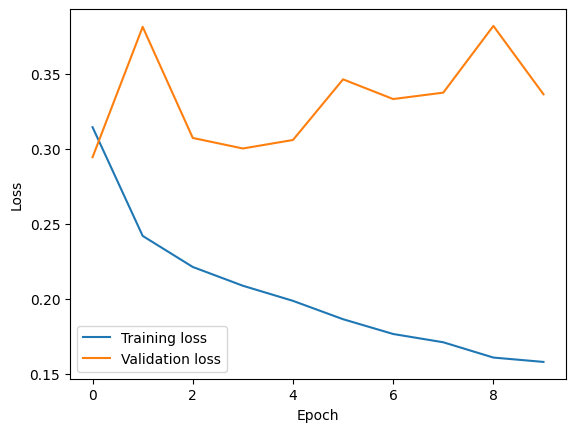

In [44]:
# Plot training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
import logging

expt_id = "34"

expt = utils.loadmat(os.path.join(RAW_DIR, f"expt{expt_id}.mat"))

In [64]:
expt["x"]["clust"][0]["vel"].shape

(1319,)

In [65]:
expt["x"]["clust"][0]["ts"].shape

(1319,)

In [66]:
expt["x"]["clust"][23]["vel"].shape

(1003,)

In [67]:
expt["x"]["clust"][23]["ts"].shape

(1003,)

Mean dip length: 2.187302779351184 seconds
Median dip length: 0.80021025 seconds
Total number of dip events: 971


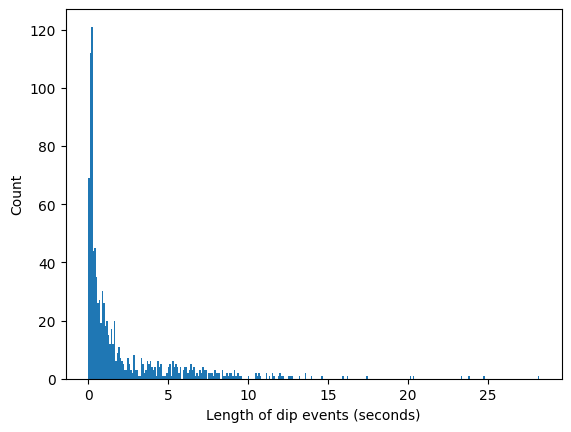

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# assuming df is your DataFrame and it has columns 'time' and 'value'
# and 'time' is in datetime format


# setting threshold
threshold = 5

df = pd.DataFrame({k: pd.Series(v) for k, v in expt["x"]["rosdata"].items()})



# create a new column 'below_threshold' to indicate whether the value is below the threshold
df['below_threshold'] = df['vel'] < threshold

# find the periods where the value dips below and then rises above the threshold
df['dip_event'] = df['below_threshold'].diff().ne(0).cumsum()

# Compute the lengths of the dips
dip_lengths_microseconds = df[df['below_threshold']].groupby('dip_event').apply(lambda x: x['encTimes'].max() - x['encTimes'].min())

# Convert lengths from microseconds to seconds
dip_lengths_in_seconds = dip_lengths_microseconds / 1_000_000


# dip_lengths = df[df['below_threshold']].groupby('dip_event').apply(lambda x: x['encTimes'].max() - x['encTimes'].min())

# # convert lengths to some numeric form, e.g., total seconds
# dip_lengths_in_seconds = dip_lengths.dt.total_seconds()

# then you can analyze the lengths, for example, plot a histogram
counts, bins, _ = plt.hist(dip_lengths_in_seconds, bins=300)
plt.xlabel('Length of dip events (seconds)')
plt.ylabel('Count');

print(f"Mean dip length: {dip_lengths_in_seconds.mean()} seconds")
print(f"Median dip length: {dip_lengths_in_seconds.median()} seconds")
print(f"Total number of dip events: {len(dip_lengths_in_seconds)}")

Mean rise length: 0.8449574409793814 seconds
Median rise length: 0.42016875 seconds
Total number of rise events: 970


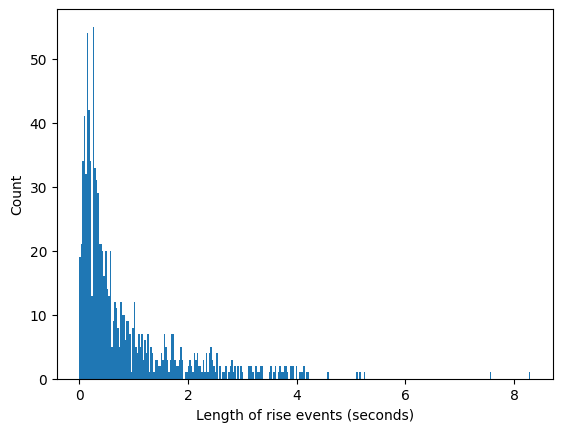

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# assuming df is your DataFrame and it has columns 'time' and 'value'
# and 'time' is in datetime format


# setting threshold
threshold = 5

df = pd.DataFrame({k: pd.Series(v) for k, v in expt["x"]["rosdata"].items()})

# create a new column 'above_threshold' to indicate whether the value is above the threshold
df['above_threshold'] = df['vel'] > threshold

# find the periods where the value rises above and then rises above the threshold
df['rise_event'] = df['above_threshold'].diff().ne(0).cumsum()

# Compute the lengths of the rises
rise_lengths_microseconds = df[df['above_threshold']].groupby('rise_event').apply(lambda x: x['encTimes'].max() - x['encTimes'].min())

# Convert lengths from microseconds to seconds
rise_lengths_in_seconds = rise_lengths_microseconds / 1_000_000


# then you can analyze the lengths, for example, plot a histogram
counts, bins, _ = plt.hist(rise_lengths_in_seconds, bins=300)
plt.xlabel('Length of rise events (seconds)')
plt.ylabel('Count')

print(f"Mean rise length: {rise_lengths_in_seconds.mean()} seconds")
print(f"Median rise length: {rise_lengths_in_seconds.median()} seconds")
print(f"Total number of rise events: {len(rise_lengths_in_seconds)}")

In [131]:
np.sum(rise_lengths_in_seconds) + np.sum(dip_lengths_in_seconds)

1639.2174355

In [135]:
(df["stopTs"] - df["startTs"])[0]*1e-6

2962.926543

In [151]:
color = df['above_threshold'][0:296298]

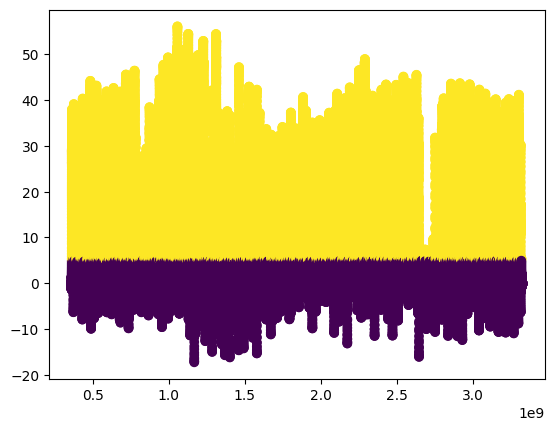

In [152]:
plt.scatter(df['encTimes'][0:296298], df['vel'][0:296298], c=color, cmap='viridis')

Text(0, 0.5, 'Velocity (deg/s)')

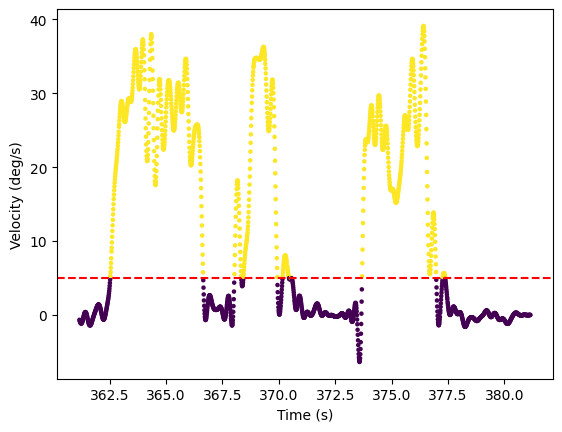

In [167]:
times_secs = df['encTimes'][0:2000]*1e-6
velocities = df['vel'][0:2000]
colors = df['above_threshold'][0:296298][0:2000]


plt.scatter(times_secs, velocities, c=colors, cmap='viridis',s=5)
plt.axhline(y=5, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (deg/s)')

In [142]:
expt["x"]["rosdata"]

{'name': 'm1',
 'startTs': 361159799,
 'stopTs': 3324086342.0,
 'encTimes': array([3.61160505e+08, 3.61171038e+08, 3.61180586e+08, ...,
        3.32406152e+09, 3.32407161e+09, 3.32408187e+09]),
 'encAngle': array([ 4446.04852284,  4446.04852284,  4446.04852284, ...,
        22023.44647206, 22023.44647206, 22023.44647206]),
 'subepochs': {'name': 'm1a', 'startTs': 361159799, 'stopTs': 2200905388.0},
 'landAngle': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'gain': array([1, 1, 1, ..., 1, 1, 1], dtype=uint8),
 'vel': array([-0.64775596, -0.75541741, -0.84847871, ...,  0.03892294,
         0.02972   ,  0.01985613]),
 'relAngle': array([ 4446.04852284,  4446.04852284,  4446.04852284, ...,
        22023.44647206, 22023.44647206, 22023.44647206]),
 'landOffTime': 2200905385.5,
 'landOffAngle': 15246.583190808291,
 'landOffIdx': 183980,
 'estGain': array([1., 1., 1., ..., 1., 1., 1.]),
 'hippAngle': array([ 4446.04852284,  4446.04852284,  4446.04852284, ...,
        22059.8015858 , 22059.80

In [174]:
(expt["x"]["rosdata"]["encTimes"][2001]-expt["x"]["rosdata"]["encTimes"][2000])*1e-3

9.996